In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
from trainers import ClassifierTrainer
from DenseNet import DenseNet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as Tr
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import random

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class CIFARDataset(Dataset):

    def __init__(self,path,filenames,transform=None):
        self.data_dict = self.load_data(path,filenames)
        self.class_names = self.unpickle(os.path.join(path,'batches.meta'))[b'label_names']
        self.class_names = list(map(lambda x: x.decode('UTF-8'), self.class_names))
        self.images = self.data_dict[b'data'].reshape(-1,3,32,32)
        self.labels = self.data_dict[b'labels']
        self.transform = transform
        
    def __getitem__(self,index):
        # Get one item from the dataset
        sample = self.images[index]
        if self.transform:
            img = Image.fromarray(sample.T)
            sample = np.asanyarray(self.transform(img))
            sample = sample.T
        sample = sample/255
        label = self.labels[index]
        sample = torch.tensor(sample).float()
        label = torch.tensor(label)
        return sample, label
    
    def __len__(self):
        return len(self.images)
    
    def load_data(self,path,filenames):
        data_dict = {}
        for filename in filenames:
            batch_dict = self.unpickle(os.path.join(path_data,filename))
            if len(data_dict)==0:
                data_dict = batch_dict
            else:
                data_dict[b'labels'] += batch_dict[b'labels']  
                data_dict[b'data'] = np.vstack((data_dict[b'data'],batch_dict[b'data']))
        return data_dict
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [3]:
def show_sample_image(dataset, idx=0, add_title=True, ax=None):
    image, label = dataset[idx]
    label = int(label.item())
    image = image.numpy().T
    flipped_image = np.zeros(image.shape)
    flipped_image[:,:, 0] = image[:,:, 0].T
    flipped_image[:,:, 1] = image[:,:, 1].T
    flipped_image[:,:, 2] = image[:,:, 2].T
    label_name = dataset.class_names[label]
    if ax is None:
        _, ax = plt.subplots(figsize=(1,1))
    ax.imshow(flipped_image, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    if add_title:
        ax.set_title(label_name)
    return flipped_image, label, label_name, ax

# Setup the datasets

In [4]:
path_data = './data/cifar-10-batches-py/'
batchfiles = os.listdir(path_data)
train_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_batches = ['test_batch']

batch_size = 100

In [5]:
transforms = Tr.Compose([Tr.Pad(4),
                         Tr.RandomHorizontalFlip(),
                         Tr.RandomCrop(32)])

In [6]:
train_dataset = CIFARDataset(path_data, train_batches, transform=transforms)
test_dataset = CIFARDataset(path_data, test_batches)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

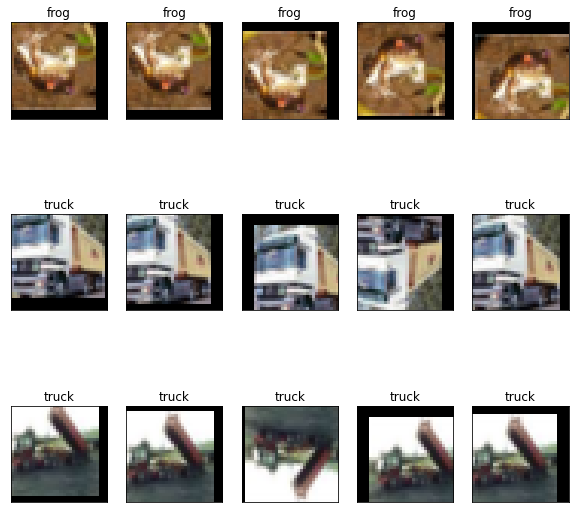

In [7]:
dataset = train_dataset

nrows = 3
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))


for i in range(nrows):
    for j in range(ncols):
        image, _, _, ax = show_sample_image(dataset, i,ax=axs[i,j], add_title=True)
    

# Network Architecture

- [source #1](https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a)
- [source #2](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html#DenseNet)

![Alt text](https://miro.medium.com/max/720/1*vIZhPImFr9Gjpx6ZB7IOJg.webp "Architecture")

![Alt text](https://miro.medium.com/max/720/1*RUiMzddMbQ0rx_CCqT2k8Q.webp "Architecture2")

In [10]:
#Learning rate
learning_rate = 1e-3
#Number of pochs
num_epochs = 200
#Initialize the model
model = DenseNet()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10**-4)
scheduler = None

In [12]:
trainer = ClassifierTrainer(model, optimizer,
                            train_loader, test_loader, False, scheduler)

In [13]:
%%time
trainer.fit(num_epochs)

Epoch 1/200, Training Loss: 1.446, Training Accuracy: 0.465, Testing Loss: 1.307, Testing Acc: 0.527
Epoch 2/200, Training Loss: 1.064, Training Accuracy: 0.618, Testing Loss: 1.198, Testing Acc: 0.568
Epoch 3/200, Training Loss: 0.918, Training Accuracy: 0.670, Testing Loss: 0.939, Testing Acc: 0.674
Epoch 4/200, Training Loss: 0.825, Training Accuracy: 0.704, Testing Loss: 0.892, Testing Acc: 0.685
Epoch 5/200, Training Loss: 0.751, Training Accuracy: 0.731, Testing Loss: 0.843, Testing Acc: 0.703
Epoch 6/200, Training Loss: 0.700, Training Accuracy: 0.752, Testing Loss: 0.968, Testing Acc: 0.669
Epoch 7/200, Training Loss: 0.650, Training Accuracy: 0.769, Testing Loss: 0.800, Testing Acc: 0.724
Epoch 8/200, Training Loss: 0.613, Training Accuracy: 0.786, Testing Loss: 0.752, Testing Acc: 0.751
Epoch 9/200, Training Loss: 0.582, Training Accuracy: 0.796, Testing Loss: 0.900, Testing Acc: 0.707
Epoch 10/200, Training Loss: 0.554, Training Accuracy: 0.805, Testing Loss: 0.741, Testing 

Epoch 82/200, Training Loss: 0.179, Training Accuracy: 0.936, Testing Loss: 0.563, Testing Acc: 0.846
Epoch 83/200, Training Loss: 0.180, Training Accuracy: 0.935, Testing Loss: 0.509, Testing Acc: 0.851
Epoch 84/200, Training Loss: 0.182, Training Accuracy: 0.934, Testing Loss: 0.490, Testing Acc: 0.859
Epoch 85/200, Training Loss: 0.180, Training Accuracy: 0.935, Testing Loss: 0.523, Testing Acc: 0.852
Epoch 86/200, Training Loss: 0.176, Training Accuracy: 0.936, Testing Loss: 0.507, Testing Acc: 0.853
Epoch 87/200, Training Loss: 0.175, Training Accuracy: 0.938, Testing Loss: 0.504, Testing Acc: 0.859
Epoch 88/200, Training Loss: 0.176, Training Accuracy: 0.937, Testing Loss: 0.531, Testing Acc: 0.853
Epoch 89/200, Training Loss: 0.177, Training Accuracy: 0.937, Testing Loss: 0.514, Testing Acc: 0.855
Epoch 90/200, Training Loss: 0.173, Training Accuracy: 0.938, Testing Loss: 0.541, Testing Acc: 0.850
Epoch 91/200, Training Loss: 0.171, Training Accuracy: 0.938, Testing Loss: 0.569,

Epoch 162/200, Training Loss: 0.137, Training Accuracy: 0.951, Testing Loss: 0.521, Testing Acc: 0.860
Epoch 163/200, Training Loss: 0.137, Training Accuracy: 0.951, Testing Loss: 0.548, Testing Acc: 0.858
Epoch 164/200, Training Loss: 0.141, Training Accuracy: 0.950, Testing Loss: 0.551, Testing Acc: 0.858
Epoch 165/200, Training Loss: 0.136, Training Accuracy: 0.951, Testing Loss: 0.493, Testing Acc: 0.867
Epoch 166/200, Training Loss: 0.136, Training Accuracy: 0.950, Testing Loss: 0.593, Testing Acc: 0.847
Epoch 167/200, Training Loss: 0.135, Training Accuracy: 0.952, Testing Loss: 0.508, Testing Acc: 0.863
Epoch 168/200, Training Loss: 0.135, Training Accuracy: 0.953, Testing Loss: 0.519, Testing Acc: 0.860
Epoch 169/200, Training Loss: 0.137, Training Accuracy: 0.951, Testing Loss: 0.521, Testing Acc: 0.862
Epoch 170/200, Training Loss: 0.138, Training Accuracy: 0.951, Testing Loss: 0.618, Testing Acc: 0.844
Epoch 171/200, Training Loss: 0.133, Training Accuracy: 0.951, Testing Lo

In [14]:
model_file = './models/cifar10_densenet_04023'
trainer.save_model(model_file)

# Model Evaluation

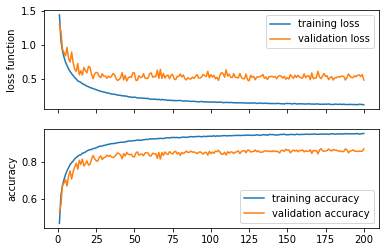

In [15]:
epochs = list(range(1,num_epochs+1))

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(epochs, trainer.train_losses)
axs[0].plot(epochs, trainer.test_losses)
axs[0].set_ylabel('loss function')
axs[0].legend(['training loss', 'validation loss'])
axs[1].plot(epochs, trainer.train_accuracies)
axs[1].plot(epochs, trainer.test_accuracies)
axs[1].set_ylabel('accuracy')
axs[1].legend(['training accuracy', 'validation accuracy'])

In [16]:
trainer.test_accuracies[-1]

0.8713998198509216

# Visualize predictions

accuracy for the presented 25 images: 0.88


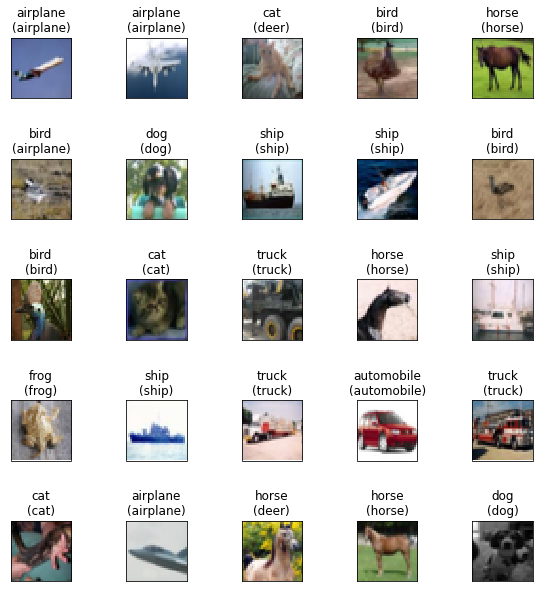

In [24]:
dataset = test_dataset

nrows = 5
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))

accuracy = 0

for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(0,len(dataset)-1)
        prediction = trainer.predict(dataset, idx)
        prediction_name = dataset.class_names[prediction]
        _, label, label_name, ax = show_sample_image(dataset, idx,ax=axs[i,j], add_title=False)
        ax.set_title(label_name + '\n(' + prediction_name +')')
        plt.subplots_adjust(hspace=1)
        accuracy +=1/(nrows*ncols)*float(prediction==label)
        
print('accuracy for the presented '+str(nrows*ncols)+' images: '+str(round(accuracy,2)))